Punto 4

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Cargar el dataset preparado en el notebook de limpieza de datos
df = pd.read_csv("df_limpio.csv")

df.head()

,TIEMPO DE GESTACION,NUMERO CONSULTAS PRENATALES,APGAR1,APGAR2,TIPO PARTO_CESAREA,TIPO PARTO_ESPONTANEO,INDICE_MASA_NEONATAL
0,37.0,7,9.0,10.0,False,True,1.209194
1,40.0,7,9.0,10.0,False,True,1.441753
2,38.0,7,9.0,10.0,False,True,1.356017
3,38.0,4,9.0,10.0,False,True,1.242644
4,35.0,4,9.0,10.0,False,True,1.252028


In [3]:
# Separar las variables predictoras (X) de la variable objetivo (y)

X = df.drop(columns='APGAR2')
y = df['APGAR2']

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


APGAR2
10.0    4868
9.0     1433
8.0      481
7.0      128
6.0       50
5.0       31
4.0        8
1.0        6
3.0        3
2.0        2
Name: count, dtype: int64

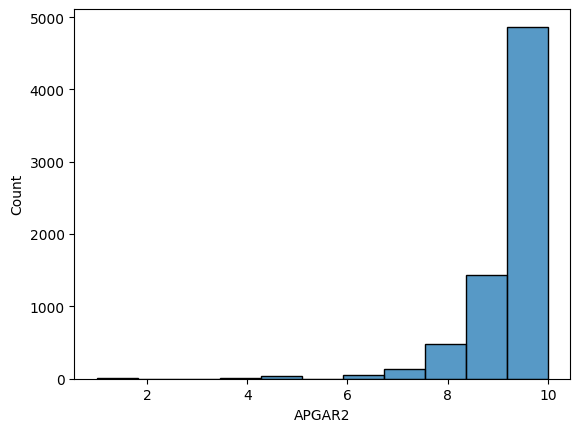

In [4]:
# Visualizar la distribución de la variable objetivo en el conjunto de entrenamiento
sns.histplot(y_train, bins=11)
y_train.value_counts()

In [5]:

# Identificar las columnas numéricas para escalarlas
numeric_cols = X.select_dtypes(include='number').columns

# Inicializar el escalador y escalar solo las columnas numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# Convertir los arrays escalados de nuevo a DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

# Combinar las columnas escaladas con las columnas no numéricas
X_train_scaled = pd.concat([X_train_scaled, X_train.drop(columns=numeric_cols)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=numeric_cols)], axis=1)


In [6]:
# Configurar la validación cruzada con 10 particiones (K-Fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
# Definir función para evaluar modelos de regresión
def evaluar_modelos(modelos, X_train_scaled, y_train, X_test_scaled, y_test):
    resultados = []# Lista para guardar los resultados de cada modelo
    errores_individuales = []  # Para guardar errores absolutos por muestra
    
    for nombre, modelo in modelos.items():
        print(f"\n=== {nombre} ===")
        
        # Validación cruzada sobre el conjunto de entrenamiento
        y_pred_cv = cross_val_predict(modelo, X_train_scaled, y_train, cv=cv)
        
        # Calcular métricas de desempeño en validación cruzada
        mae_cv = mean_absolute_error(y_train, y_pred_cv)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        rmse_cv = mse_cv ** 0.5
        r2_cv = r2_score(y_train, y_pred_cv)
        print(f"CV - MAE: {mae_cv:.3f}, RMSE: {rmse_cv:.3f}, R2: {r2_cv:.3f}")
        
        # Evaluar desempeño en el conjunto de prueba
        modelo.fit(X_train_scaled, y_train)
        y_pred_test = modelo.predict(X_test_scaled)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_pred_test)
        print(f"Test - MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}")
        
        # Guardar resultados del modelo
        resultados.append({
            "Modelo": nombre,
            "MAE_CV": mae_cv, "RMSE_CV": rmse_cv, "R2_CV": r2_cv,
            "MAE_Test": mae_test, "RMSE_Test": rmse_test, "R2_Test": r2_test
        })
        
        # Guardar errores absolutos individuales para ANOVA/Tukey
        errores = np.abs(y_test - y_pred_test)
        for e in errores:
            errores_individuales.append({"Modelo": nombre, "Error_Absoluto": e})
        
        # Graficar predicciones vs valores reales en test
        sns.scatterplot(x=y_test, y=y_pred_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valor Real")
        plt.ylabel("Predicción")
        plt.title(f"Predicción vs Real - {nombre}")
        plt.show()
        
    # Crear DataFrames
    df_resultados = pd.DataFrame(resultados)
    df_errores = pd.DataFrame(errores_individuales)

    return df_resultados, df_errores

MODELOS SUPERVISADOS

In [8]:
# Definir modelos de aprendizaje supervisado
modelos_supervisados = {
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(max_iter=1000, random_state=42),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}


=== SVR ===
CV - MAE: 0.313, RMSE: 0.573, R2: 0.589
Test - MAE: 0.307, RMSE: 0.563, R2: 0.594


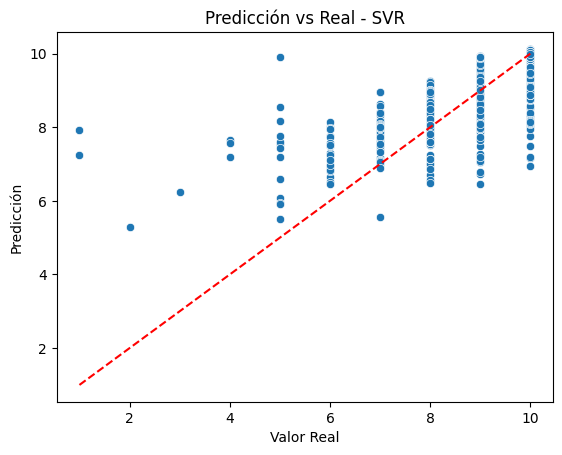


=== MLP Regressor ===
CV - MAE: 0.326, RMSE: 0.533, R2: 0.644
Test - MAE: 0.308, RMSE: 0.500, R2: 0.680


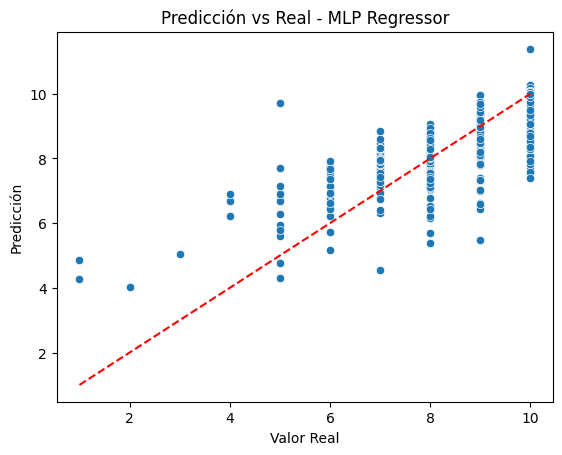


=== KNN ===
CV - MAE: 0.316, RMSE: 0.577, R2: 0.583
Test - MAE: 0.300, RMSE: 0.540, R2: 0.626


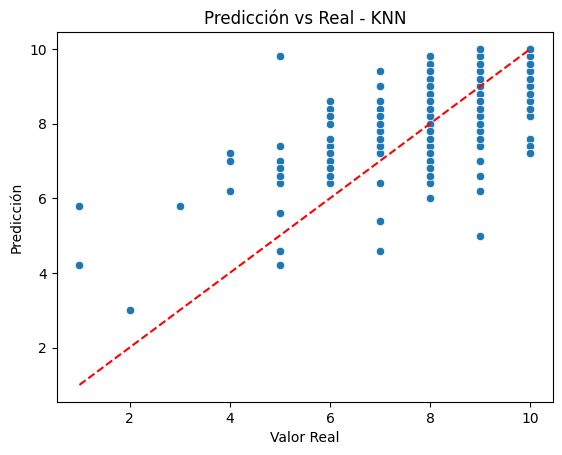


=== Decision Tree ===
CV - MAE: 0.342, RMSE: 0.745, R2: 0.305
Test - MAE: 0.316, RMSE: 0.719, R2: 0.339


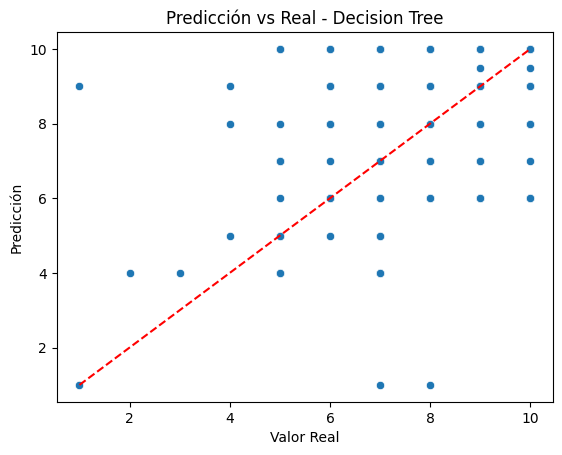

In [9]:
# Evaluar modelos supervisados 
resultados_supervisados, errores_supervisados = evaluar_modelos(modelos_supervisados, X_train_scaled, y_train, X_test_scaled, y_test)

Métodos de ensamble

In [10]:
# Definir modelos de aprendizaje supervisado

ensambles = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Bagging (Tree)": BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)
}


=== Random Forest ===


CV - MAE: 0.311, RMSE: 0.565, R2: 0.601
Test - MAE: 0.296, RMSE: 0.546, R2: 0.618


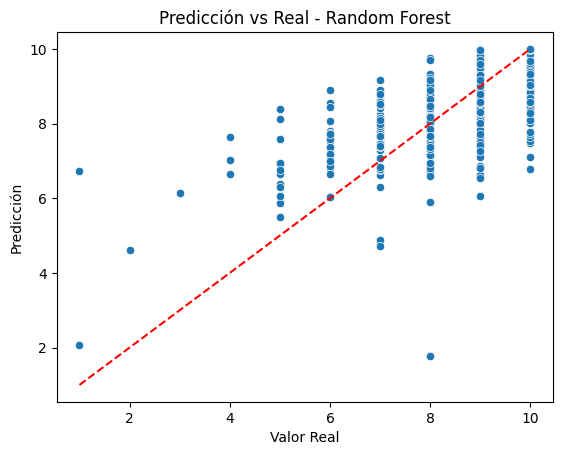


=== Gradient Boosting ===
CV - MAE: 0.315, RMSE: 0.531, R2: 0.647
Test - MAE: 0.305, RMSE: 0.530, R2: 0.640


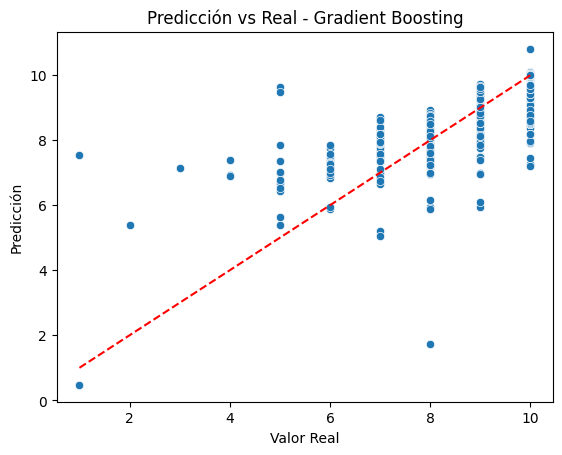


=== Bagging (Tree) ===
CV - MAE: 0.311, RMSE: 0.580, R2: 0.580
Test - MAE: 0.300, RMSE: 0.562, R2: 0.596


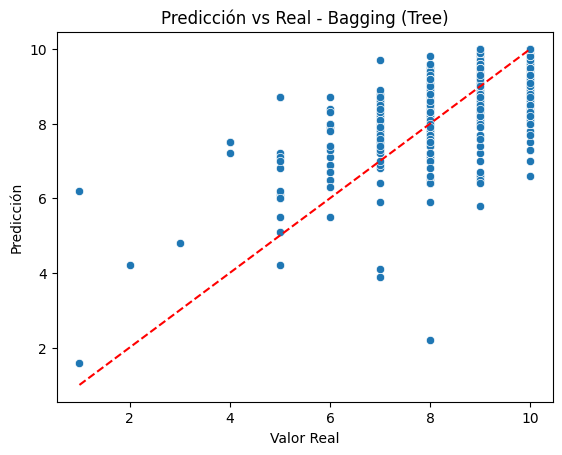

In [11]:
# Evaluar modelos de ensamble
resultados_ensamble, errores_ensamble = evaluar_modelos(ensambles, X_train_scaled, y_train, X_test_scaled, y_test)

In [12]:
# Combinar y mostrar resultados finales
todos_resultados = pd.concat([resultados_supervisados, resultados_ensamble], ignore_index=True)

# Mostrar como tabla 
display(todos_resultados)

# Ordenar por R2 en test para ver el mejor modelo primero
print("\nModelos ordenados por desempeño en Test (R2):")
print(todos_resultados.sort_values(by="R2_Test", ascending=False))


,Modelo,MAE_CV,RMSE_CV,R2_CV,MAE_Test,RMSE_Test,R2_Test
0,SVR,0.312713,0.572942,0.589439,0.307287,0.562936,0.594353
1,MLP Regressor,0.325548,0.533390,0.644167,0.307561,0.500348,0.679539
2,KNN,0.316291,0.577139,0.583402,0.300499,0.540229,0.626418
3,Decision Tree,0.342368,0.745409,0.305063,0.316473,0.718776,0.338671
4,Random Forest,0.310873,0.564992,0.600754,0.296128,0.546298,0.617977
5,Gradient Boosting,0.315064,0.531069,0.647258,0.304885,0.530486,0.639771
6,Bagging (Tree),0.311459,0.579509,0.579974,0.299664,0.561512,0.596403



Modelos ordenados por desempeño en Test (R2):
              Modelo    MAE_CV   RMSE_CV     R2_CV  MAE_Test  RMSE_Test  \
1      MLP Regressor  0.325548  0.533390  0.644167  0.307561   0.500348   
5  Gradient Boosting  0.315064  0.531069  0.647258  0.304885   0.530486   
2                KNN  0.316291  0.577139  0.583402  0.300499   0.540229   
4      Random Forest  0.310873  0.564992  0.600754  0.296128   0.546298   
6     Bagging (Tree)  0.311459  0.579509  0.579974  0.299664   0.561512   
0                SVR  0.312713  0.572942  0.589439  0.307287   0.562936   
3      Decision Tree  0.342368  0.745409  0.305063  0.316473   0.718776   

    R2_Test  
1  0.679539  
5  0.639771  
2  0.626418  
4  0.617977  
6  0.596403  
0  0.594353  
3  0.338671  


**Interpretación de métricas obtenidas por los modelos**

Para evaluar el rendimiento de los modelos de regresión en la predicción del puntaje APGAR a los 5 minutos (APGAR2), se utilizaron cuatro métricas clave:

MAE (Mean Absolute Error): representa el error promedio absoluto entre las predicciones y los valores reales. Indica, en promedio, cuántos puntos se equivoca el modelo al predecir.

RMSE (Root Mean Squared Error): penaliza más los errores grandes y ayuda a identificar qué tan dispersos son los errores del modelo.

R² (Coeficiente de determinación): refleja el porcentaje de la variabilidad de la variable objetivo que es explicada por el modelo. Un valor cercano a 1 indica mejor capacidad predictiva.

A continuación, se interpreta el desempeño de cada modelo según los resultados en el conjunto de prueba:

🔹 MLP Regressor
Este modelo tuvo el mejor desempeño global. Con un R² de 0.6795, fue el que más porcentaje de variabilidad logró explicar. Su MAE de 0.31 y RMSE de 0.50 indican predicciones muy precisas y consistentes, sin errores extremos significativos.

🔹 Gradient Boosting
Se posiciona como el segundo mejor modelo, con R² = 0.6398 y errores bajos (MAE = 0.30, RMSE = 0.53). Ofrece un equilibrio sólido entre precisión promedio y robustez general.

🔹 KNN Regressor
Este modelo obtuvo el MAE más bajo (0.30), lo cual indica una gran precisión en la mayoría de sus predicciones. Sin embargo, su RMSE más alto (0.54) revela que presenta algunos errores más grandes, aunque su desempeño general es bueno (R² = 0.6264).

🔹 Random Forest
Mostró un muy bajo MAE (0.2961), lo que refleja gran precisión. Sin embargo, su RMSE algo más alto (0.55) y R² de 0.6180 indican que, aunque preciso, puede cometer errores más dispersos.

🔹 Bagging con Árboles
Obtuvo resultados similares a Random Forest, aunque con un R² ligeramente inferior (0.5964). Aun así, se mantiene como una opción válida con buen balance entre error medio y capacidad explicativa.

🔹 SVR (Support Vector Regressor)
Con R² de 0.5944, este modelo fue preciso en términos de MAE (0.3073), pero su RMSE indica mayor sensibilidad a errores extremos, por lo que su estabilidad no es tan fuerte como la de los modelos anteriores.

🔻 Decision Tree
Este fue el modelo con peor desempeño. Con un R² de apenas 0.3387, y los valores más altos de MAE (0.3165) y RMSE (0.7188), queda claro que no logra generalizar bien, probablemente por sobreajuste o alta varianza.

In [13]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [14]:
errores_individuales = pd.concat([errores_supervisados, errores_ensamble], ignore_index=True)

In [15]:
# Agrupar errores por modelo
grupos = [errores_individuales[errores_individuales['Modelo'] == m]['Error_Absoluto']
          for m in errores_individuales['Modelo'].unique()]

# Prueba ANOVA
anova = f_oneway(*grupos)

print("=== ANOVA ===")
print(f"F-statistic: {anova.statistic:.4f}")
print(f"p-value: {anova.pvalue:.4f}")

=== ANOVA ===
F-statistic: 0.5837
p-value: 0.7437


In [16]:
# Tukey HSD
tukey = pairwise_tukeyhsd(endog=errores_individuales['Error_Absoluto'],
                          groups=errores_individuales['Modelo'],
                          alpha=0.05)

print("\n=== Tukey HSD ===")
print(tukey.summary())



=== Tukey HSD ===
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
   Bagging (Tree)     Decision Tree   0.0168 0.8263 -0.0198 0.0534  False
   Bagging (Tree) Gradient Boosting   0.0052 0.9996 -0.0314 0.0418  False
   Bagging (Tree)               KNN   0.0008    1.0 -0.0358 0.0374  False
   Bagging (Tree)     MLP Regressor   0.0079 0.9956 -0.0287 0.0445  False
   Bagging (Tree)     Random Forest  -0.0035    1.0 -0.0401 0.0331  False
   Bagging (Tree)               SVR   0.0076 0.9964  -0.029 0.0442  False
    Decision Tree Gradient Boosting  -0.0116 0.9673 -0.0482  0.025  False
    Decision Tree               KNN   -0.016 0.8584 -0.0526 0.0206  False
    Decision Tree     MLP Regressor  -0.0089 0.9916 -0.0455 0.0277  False
    Decision Tree     Random Forest  -0.0203 0.6572  -0.057 0.0163  False
    Decision Tree  

c:\Users\alexa\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


**Interpretación del análisis estadístico (ANOVA y Tukey)**

Para determinar si existían diferencias estadísticamente significativas entre los modelos aplicados al problema de predicción de APGAR2, se aplicaron dos pruebas:

1. ANOVA (Análisis de Varianza)
El objetivo de esta prueba fue comparar los errores absolutos individuales obtenidos por cada modelo en el conjunto de prueba.

F-statistic: 0.5837

p-value: 0.7437

El valor-p es mucho mayor que 0.05, lo que indica que no hay evidencia estadísticamente significativa para afirmar que existen diferencias entre los errores de los modelos evaluados.

2. Tukey HSD (Prueba de comparaciones múltiples)
Esta prueba se aplicó para identificar si existen diferencias significativas entre pares específicos de modelos.

Todos los valores de reject en la tabla son False, lo que confirma que ninguna diferencia entre modelos es estadísticamente significativa.

Los intervalos de confianza para las diferencias de medias de error siempre incluyen el 0, y los valores p-adj son todos muy superiores a 0.05.

Conclusión
Aunque algunos modelos obtuvieron mejores métricas (como menor MAE o mayor R²), estadísticamente, no se detectaron diferencias significativas entre sus desempeños en términos de error absoluto. Esto sugiere que, desde una perspectiva estadística, los 7 modelos tienen un comportamiento comparativamente similar al predecir APGAR2 en el conjunto de prueba.

Sin embargo, por razones prácticas y de interpretación, es mejor seleccionar los modelos con mejor combinación de MAE bajo, RMSE bajo y R² alto, como lo son en este caso:

**MLP Regressor, Gradient Boosting y KNN Regressor** 